# Subjectivity in News Articles

## Group:
- Luca Babboni - luca.babboni2@studio.unibo.it
- Matteo Fasulo - matteo.fasulo@studio.unibo.it
- Luca Tedeschini - luca.tedeschini3@studio.unibo.it

## Description

This notebook addresses Task 1 proposed in [CheckThat Lab](https://checkthat.gitlab.io/clef2025/) of CLEF 2025. In this task, systems are challenged to distinguish whether a sentence from a news article expresses the subjective view of the author behind it or presents an objective view on the covered topic instead.

This is a binary classification tasks in which systems have to identify whether a text sequence (a sentence or a paragraph) is subjective (SUBJ) or objective (OBJ).

The task comprises three settings:

* Monolingual: train and test on data in a given language
* Multilingual: train and test on data comprising several languages
* Zero-shot: train on several languages and test on unseen languages

training data in five languages:
* Arabic
* Bulgarian
* English
* German
* Italian

The official evaluation is macro-averaged F1 between the two classes.

In [1]:
from collections import defaultdict
import os
import gc
from pathlib import Path

import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

from joblib import delayed, Parallel

from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sentence_transformers import SentenceTransformer
from datasets import Dataset
from huggingface_hub import notebook_login
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, RobertaTokenizerFast, RobertaForSequenceClassification, pipeline, get_linear_schedule_with_warmup

/home/ubuntu/clef2025-checkthat/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [3]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [19]:
class Subjectivity:
    def __init__(self, data_folder: str = 'data', seed: int = 42, device: str = 'cuda'):
        self.seed = seed
        self.device = device
        self.languages = [language for language in os.listdir(data_folder)]

        dataset = self.create_dataset(data_folder=data_folder)
        self.dataset = dataset
        
        train, dev, test = self.get_splits(dataset, print_shapes=True)
        self.train = train
        self.dev = dev
        self.test = test

        self.all_data = self.get_per_lang_dataset()
        

    def create_dataset(self, data_folder: str = 'data'):
        dataset = pd.DataFrame(columns=['sentence_id','sentence','label','lang','split'])
        for language in os.listdir(data_folder):
            for filename in os.listdir(f"{data_folder}{os.sep}{language}"):
                if '.tsv' in filename:
                    abs_path = f"{data_folder}{os.sep}{language}{os.sep}{filename}"
                    df = pd.read_csv(abs_path, sep='\t', quoting=csv.QUOTE_NONE)
                    if 'solved_conflict' in df.columns:
                        df.drop(columns=['solved_conflict'], inplace=True)
                    df['lang'] = language
                    df['split'] = Path(filename).stem
                    dataset = pd.concat([dataset, df], axis=0)
        return dataset

    def get_splits(self, dataset: pd.DataFrame, print_shapes: bool = True):
        train = dataset[dataset['split'].str.contains('train')].copy()
        dev = dataset[(dataset['split'].str.contains('dev')) & ~(dataset['split'].str.contains('dev_test'))].copy()
        test = dataset[dataset['split'].str.contains('dev_test')].copy()

        # encode the target variable to int (0: obj; 1: subj)
        train.loc[:, 'label'] = train['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
        dev.loc[:, 'label'] = dev['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
        test.loc[:, 'label'] = test['label'].apply(lambda x: 0 if x == 'OBJ' else 1)

        # cast to int
        train['label'] = train['label'].astype(int)
        dev['label'] = dev['label'].astype(int)
        test['label'] = test['label'].astype(int)

        if print_shapes:
            print(f"Train: {train.shape}")
            print(f"Dev: {dev.shape}")
            print(f"Test: {test.shape}")
            
        return train, dev, test

    def get_per_lang_dataset(self):
        """
        dataset_dict = {
            'english': {
                'train': ...
                'dev': ...
                'test': ...
            },
        }
        """
        dataset_dict = {}
        for language in self.languages:
            dataset_dict[language] = {}
            # get the train data
            dataset_dict[language]['train'] = self.train[self.train['lang']==language].copy()
            # get the dev data
            dataset_dict[language]['dev'] = self.dev[self.dev['lang']==language].copy()
            # get the test data
            dataset_dict[language]['test'] = self.test[self.test['lang']==language].copy()
        return dataset_dict

    def print_label_distrib(self, dataset: pd.DataFrame):
        print(dataset['label'].value_counts(normalize=True))

    def get_baseline_model(self, model_name: str = "paraphrase-multilingual-MiniLM-L12-v2"):
        vect = SentenceTransformer(model_name)
        self.vect = vect
        return vect

    def train_baseline_model(self, vect, train_data: pd.DataFrame, test_data: pd.DataFrame, solver: str = 'saga'):
        model = LogisticRegression(class_weight="balanced", solver=solver, random_state=self.seed)
        model.fit(X=vect.encode(train_data['sentence'].values), y=train_data['label'].values)
        predictions = model.predict(X=vect.encode(test_data['sentence'].values)).tolist()

        # eval performances
        perfs = self.evaluate_model(gold_values=test_data['label'].values, predicted_values=predictions)

        return perfs

    def get_tokenizer(self, model_card: str = "microsoft/mdeberta-v3-base"):
        tokenizer = AutoTokenizer.from_pretrained(model_card)
        self.tokenizer = tokenizer
        return tokenizer

    def get_model(self, model_card: str = "microsoft/mdeberta-v3-base", *args, **kwargs):
        model = AutoModelForSequenceClassification.from_pretrained(model_card, *args, **kwargs)
        self.model = model
        return model

    def get_class_weights(self, dataset: pd.DataFrame):
        class_weights = compute_class_weight('balanced', classes=np.unique(dataset['label']), y=dataset['label'])
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.device)
        return class_weights

    def evaluate_model(self, gold_values, predicted_values):
        acc = accuracy_score(gold_values, predicted_values)
        m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(gold_values, predicted_values, average="macro",
                                                                   zero_division=0)
        p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(gold_values, predicted_values, labels=[1],
                                                                   zero_division=0)
    
        return {
            'macro_F1': m_f1,
            'macro_P': m_prec,
            'macro_R': m_rec,
            'SUBJ_F1': p_f1[0],
            'SUBJ_P': p_prec[0],
            'SUBJ_R': p_rec[0],
            'accuracy': acc
        }

In [ ]:
data_folder = '/kaggle/input/clef2025-checkthat/data' # data

In [9]:
detector = Subjectivity(data_folder=data_folder, seed=SEED, device=device)

Train: (6418, 5)
Dev: (2401, 5)
Test: (2332, 5)


In [10]:
detector.print_label_distrib(detector.train)
detector.print_label_distrib(detector.dev)
detector.print_label_distrib(detector.test)

label
0    0.631349
1    0.368651
Name: proportion, dtype: float64
label
0    0.612245
1    0.387755
Name: proportion, dtype: float64
label
0    0.657376
1    0.342624
Name: proportion, dtype: float64


In [11]:
#notebook_login()

In [12]:
results = {}

# Baseline Model (English)

In [13]:
vect = detector.get_baseline_model(model_name="paraphrase-multilingual-MiniLM-L12-v2")
vect

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [14]:
detector.train_baseline_model(vect, detector.all_data['english']['train'], detector.all_data['english']['test'])

/home/ubuntu/clef2025-checkthat/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'macro_F1': 0.6328683996014853,
 'macro_P': 0.6328683996014853,
 'macro_R': 0.6328683996014853,
 'SUBJ_F1': np.float64(0.45081967213114754),
 'SUBJ_P': np.float64(0.45081967213114754),
 'SUBJ_R': np.float64(0.45081967213114754),
 'accuracy': 0.7231404958677686}

# Baseline Model (italian)

In [15]:
detector.train_baseline_model(vect, detector.all_data['italian']['train'], detector.all_data['italian']['test'])

{'macro_F1': 0.6320502510378405,
 'macro_P': 0.6294871794871795,
 'macro_R': 0.656605944765174,
 'SUBJ_F1': np.float64(0.5015105740181269),
 'SUBJ_P': np.float64(0.4256410256410256),
 'SUBJ_R': np.float64(0.6102941176470589),
 'accuracy': 0.6783625730994152}

# Baseline Model (multilingual)

In [16]:
detector.train_baseline_model(vect, detector.train, detector.test)

{'macro_F1': 0.6220011992495019,
 'macro_P': 0.6223227143343395,
 'macro_R': 0.633496534725811,
 'SUBJ_F1': np.float64(0.538037486218302),
 'SUBJ_P': np.float64(0.4807881773399015),
 'SUBJ_R': np.float64(0.6107634543178974),
 'accuracy': 0.6406518010291595}

# mDeBERTta v3 base (Arabic)

In [69]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


1447

In [70]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/home/ubuntu/clef2025-checkthat/.venv/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
# Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L3700 (with some minor changes removing useless parts)
class CustomTrainer(Trainer):
    def __init__(self, class_weights, device, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # You pass the class weights when instantiating the Trainer
        self.class_weights = class_weights
        self.device = device

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            # We extract the logits from the model outputs
            logits = outputs.get('logits')
            # We compute the loss manually passing the class weights to the loss function
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(self.device)) # Modified to use the class weights
            # We compute the loss using the modified criterion
            loss = criterion(logits, inputs['labels'])

        return (loss, outputs) if return_outputs else loss

In [72]:
def tokenize_text(texts):
    return tokenizer(texts['sentence'], padding=True, truncation=True, max_length=256, return_tensors='pt')

def evaluate_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                                zero_division=0)
    p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                                zero_division=0)

    return {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

In [73]:
language = 'arabic'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map: 100%|██████████| 748/748 [00:00<00:00, 9541.26 examples/s]


In [74]:
# Define training args
training_args = TrainingArguments(
    output_dir= "models",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #bf16=True, # bfloat16 training 
    #optim="adamw_torch_fused", # improved optimizer 
    # logging & evaluation strategies
    #logging_strategy="steps",
    #logging_steps=100,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    #use_mps_device=True,
    metric_for_best_model="macro_F1",
    # push to hub parameters
    #push_to_hub=True,
    #hub_strategy="every_save",
    #hub_token=HfFolder.get_token(),
)

In [75]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights,
    device=device,
)

In [76]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.694950,0.441792,0.559805,0.517796,0.168067,0.540541,0.099502,0.576017
2,No log,0.695104,0.551732,0.551654,0.551996,0.495098,0.487923,0.502488,0.558887
3,No log,0.702194,0.545204,0.546435,0.545309,0.466321,0.486486,0.447761,0.558887
4,0.675300,0.746640,0.549228,0.549400,0.550060,0.500000,0.483721,0.517413,0.554604
5,0.675300,0.765201,0.553379,0.561876,0.556148,0.448179,0.512821,0.398010,0.578158
6,0.675300,0.804508,0.550278,0.550250,0.550724,0.496350,0.485714,0.507463,0.556745


TrainOutput(global_step=918, training_loss=0.6385969440402028, metrics={'train_runtime': 291.6103, 'train_samples_per_second': 50.327, 'train_steps_per_second': 3.148, 'total_flos': 1259508487212432.0, 'train_loss': 0.6385969440402028, 'epoch': 6.0})

{'macro_F1': 0.565763113161729, 'macro_P': 0.5764920680001623, 'macro_R': 0.5686687306501548, 'SUBJ_F1': np.float64(0.4612676056338028), 'SUBJ_P': np.float64(0.5346938775510204), 'SUBJ_R': np.float64(0.4055727554179567), 'accuracy': 0.5909090909090909}


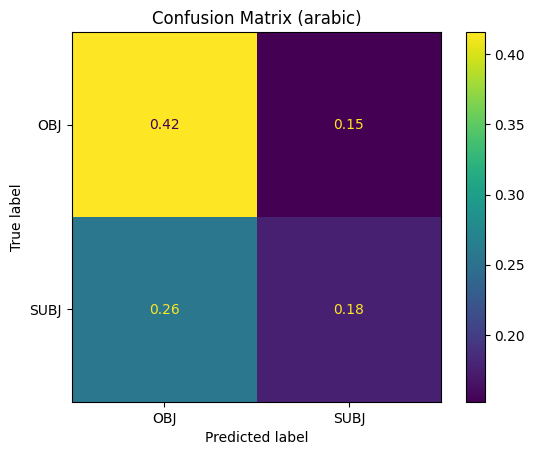

In [77]:
test_predictions, test_labels, _ = trainer.predict(test_data)

stats = evaluate_metrics((test_predictions, test_labels))

test_predictions = np.argmax(test_predictions, axis=1)

print(stats)
results[language] = stats

cm = confusion_matrix(test_labels, test_predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTta v3 base (Bulgarian)

In [78]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5675

In [79]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/home/ubuntu/clef2025-checkthat/.venv/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
language = 'bulgarian'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/729 [00:00<?, ? examples/s]

Map: 100%|██████████| 250/250 [00:00<00:00, 10404.29 examples/s]


In [81]:
# Define training args
training_args = TrainingArguments(
    output_dir= "models",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #bf16=True, # bfloat16 training 
    #optim="adamw_torch_fused", # improved optimizer 
    # logging & evaluation strategies
    #logging_strategy="steps",
    #logging_steps=100,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    #use_mps_device=True,
    metric_for_best_model="macro_F1",
    # push to hub parameters
    #push_to_hub=True,
    #hub_strategy="every_save",
    #hub_token=HfFolder.get_token(),
)

In [82]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights,
    device=device,
)

In [83]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.685650,0.306843,0.221338,0.500000,0.613687,0.442675,1.000000,0.442675
2,No log,0.573852,0.769767,0.770014,0.773566,0.755102,0.716129,0.798561,0.770701
3,No log,0.503133,0.808511,0.810856,0.807009,0.782288,0.803030,0.762590,0.812102
4,No log,0.423324,0.825985,0.825565,0.826475,0.807143,0.801418,0.812950,0.828025
5,No log,0.415053,0.838138,0.839396,0.837163,0.817518,0.829630,0.805755,0.840764
6,No log,0.414228,0.841752,0.842021,0.841501,0.823105,0.826087,0.820144,0.843949


TrainOutput(global_step=276, training_loss=0.46358277141184046, metrics={'train_runtime': 110.0359, 'train_samples_per_second': 39.751, 'train_steps_per_second': 2.508, 'total_flos': 334920685341096.0, 'train_loss': 0.46358277141184046, 'epoch': 6.0})

{'macro_F1': 0.7574771041944129, 'macro_P': 0.7595389507154213, 'macro_R': 0.7560616953140318, 'SUBJ_F1': np.float64(0.7177033492822966), 'SUBJ_P': np.float64(0.7352941176470589), 'SUBJ_R': np.float64(0.7009345794392523), 'accuracy': 0.764}


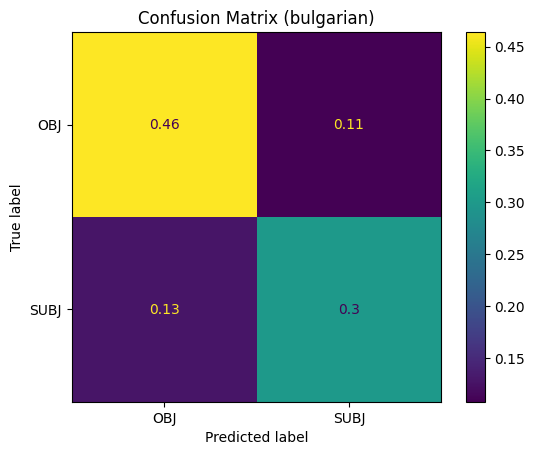

In [84]:
test_predictions, test_labels, _ = trainer.predict(test_data)

stats = evaluate_metrics((test_predictions, test_labels))

test_predictions = np.argmax(test_predictions, axis=1)

print(stats)
results[language] = stats

cm = confusion_matrix(test_labels, test_predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTa-base (English)

In [85]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5987

In [86]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/home/ubuntu/clef2025-checkthat/.venv/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map: 100%|██████████| 484/484 [00:00<00:00, 8148.46 examples/s]


In [88]:
# Define training args
training_args = TrainingArguments(
    output_dir= "models",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #bf16=True, # bfloat16 training 
    #optim="adamw_torch_fused", # improved optimizer 
    # logging & evaluation strategies
    #logging_strategy="steps",
    #logging_steps=100,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    #use_mps_device=True,
    metric_for_best_model="macro_F1",
    # push to hub parameters
    #push_to_hub=True,
    #hub_strategy="every_save",
    #hub_token=HfFolder.get_token(),
)

In [89]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights,
    device=device,
)

In [90]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.689353,0.542208,0.712750,0.606982,0.389610,0.882353,0.250000,0.593074
2,No log,0.476692,0.749148,0.770801,0.750394,0.788785,0.715254,0.879167,0.755411
3,No log,0.660809,0.745174,0.776274,0.754786,0.714286,0.873494,0.604167,0.748918
4,No log,0.592936,0.778286,0.790799,0.782939,0.763889,0.859375,0.687500,0.779221
5,No log,0.618215,0.780397,0.793561,0.785191,0.765661,0.863874,0.687500,0.781385
6,No log,0.591518,0.789609,0.797592,0.793018,0.780045,0.855721,0.716667,0.790043


TrainOutput(global_step=312, training_loss=0.4247337732559595, metrics={'train_runtime': 130.7332, 'train_samples_per_second': 38.093, 'train_steps_per_second': 2.387, 'total_flos': 445302891493920.0, 'train_loss': 0.4247337732559595, 'epoch': 6.0})

{'macro_F1': 0.6751503436426117, 'macro_P': 0.736783988957902, 'macro_R': 0.6553754188932162, 'SUBJ_F1': np.float64(0.4791666666666667), 'SUBJ_P': np.float64(0.6571428571428571), 'SUBJ_R': np.float64(0.3770491803278688), 'accuracy': 0.7933884297520661}


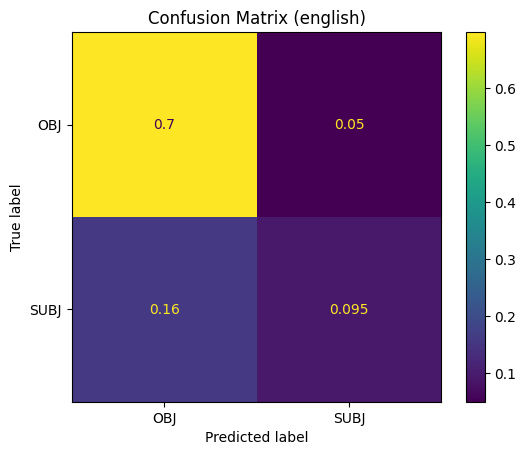

In [91]:
test_predictions, test_labels, _ = trainer.predict(test_data)

stats = evaluate_metrics((test_predictions, test_labels))

test_predictions = np.argmax(test_predictions, axis=1)

print(stats)
results[language] = stats

cm = confusion_matrix(test_labels, test_predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTta v3 base (German)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

In [ ]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

In [92]:
language = 'german'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/491 [00:00<?, ? examples/s]

Map: 100%|██████████| 337/337 [00:00<00:00, 9455.16 examples/s]


In [93]:
# Define training args
training_args = TrainingArguments(
    output_dir= "models",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #bf16=True, # bfloat16 training 
    #optim="adamw_torch_fused", # improved optimizer 
    # logging & evaluation strategies
    #logging_strategy="steps",
    #logging_steps=100,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    #use_mps_device=True,
    metric_for_best_model="macro_F1",
    # push to hub parameters
    #push_to_hub=True,
    #hub_strategy="every_save",
    #hub_token=HfFolder.get_token(),
)

In [94]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights,
    device=device,
)

In [95]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.514818,0.763438,0.758745,0.774647,0.708995,0.656863,0.770115,0.775967
2,No log,0.524952,0.784603,0.781600,0.788390,0.726257,0.706522,0.747126,0.800407
3,No log,0.640416,0.758722,0.759041,0.782316,0.717445,0.626609,0.839080,0.765784
4,No log,0.632269,0.782219,0.777792,0.789124,0.726776,0.692708,0.764368,0.796334
5,No log,0.686507,0.779967,0.779611,0.780331,0.716332,0.714286,0.718391,0.798371
6,No log,0.703627,0.776421,0.771769,0.784392,0.720867,0.682051,0.764368,0.790224


TrainOutput(global_step=300, training_loss=0.27254806518554686, metrics={'train_runtime': 122.8066, 'train_samples_per_second': 39.086, 'train_steps_per_second': 2.443, 'total_flos': 404540502451200.0, 'train_loss': 0.27254806518554686, 'epoch': 6.0})

{'macro_F1': 0.8372606411810504, 'macro_P': 0.8338469339990638, 'macro_R': 0.8411663876265647, 'SUBJ_F1': np.float64(0.7841409691629956), 'SUBJ_P': np.float64(0.7672413793103449), 'SUBJ_R': np.float64(0.8018018018018018), 'accuracy': 0.8545994065281899}


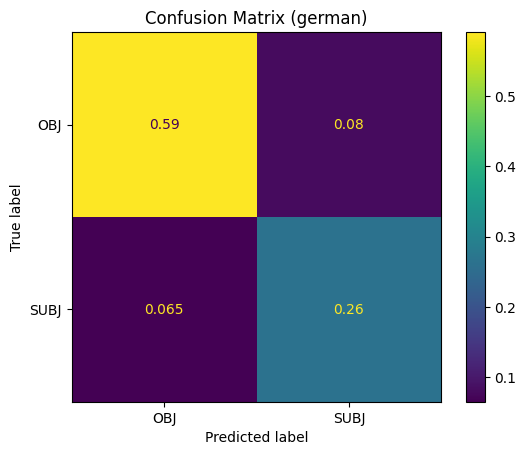

In [96]:
test_predictions, test_labels, _ = trainer.predict(test_data)

stats = evaluate_metrics((test_predictions, test_labels))

test_predictions = np.argmax(test_predictions, axis=1)

print(stats)
results[language] = stats

cm = confusion_matrix(test_labels, test_predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTa-base (italian)

In [97]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5687

In [98]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/home/ubuntu/clef2025-checkthat/.venv/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [99]:
language = 'italian'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/1613 [00:00<?, ? examples/s]

Map: 100%|██████████| 513/513 [00:00<00:00, 10844.00 examples/s]


In [100]:
# Define training args
training_args = TrainingArguments(
    output_dir= "models",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #bf16=True, # bfloat16 training 
    #optim="adamw_torch_fused", # improved optimizer 
    # logging & evaluation strategies
    #logging_strategy="steps",
    #logging_steps=100,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    #use_mps_device=True,
    metric_for_best_model="macro_F1",
    # push to hub parameters
    #push_to_hub=True,
    #hub_strategy="every_save",
    #hub_token=HfFolder.get_token(),
)

In [101]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights,
    device=device,
)

In [102]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.630749,0.568457,0.624721,0.654502,0.506993,0.367089,0.819209,0.577211
2,No log,0.538592,0.736566,0.734937,0.738285,0.614525,0.607735,0.621469,0.793103
3,No log,0.562935,0.743027,0.735401,0.753505,0.631300,0.595000,0.672316,0.791604
4,No log,0.631243,0.750640,0.746619,0.755235,0.637363,0.620321,0.655367,0.802099
5,0.433600,0.699200,0.755040,0.752070,0.758296,0.642659,0.630435,0.655367,0.806597
6,0.433600,0.689947,0.757199,0.747329,0.772259,0.654545,0.605769,0.711864,0.800600


TrainOutput(global_step=606, training_loss=0.39867654177221923, metrics={'train_runtime': 222.7462, 'train_samples_per_second': 43.449, 'train_steps_per_second': 2.721, 'total_flos': 810681283261944.0, 'train_loss': 0.39867654177221923, 'epoch': 6.0})

{'macro_F1': 0.7426974611287587, 'macro_P': 0.7382308845577211, 'macro_R': 0.7479325947885787, 'SUBJ_F1': np.float64(0.6263345195729537), 'SUBJ_P': np.float64(0.6068965517241379), 'SUBJ_R': np.float64(0.6470588235294118), 'accuracy': 0.7953216374269005}


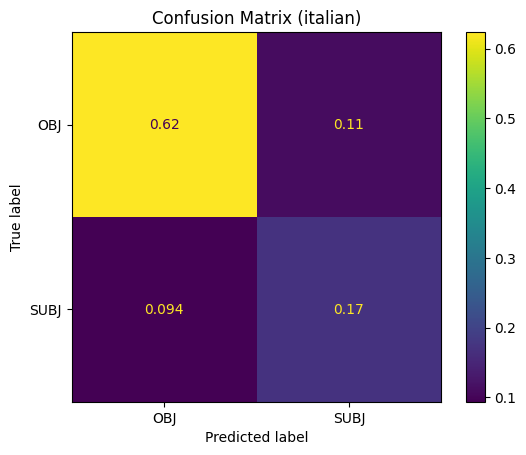

In [103]:
test_predictions, test_labels, _ = trainer.predict(test_data)

stats = evaluate_metrics((test_predictions, test_labels))

test_predictions = np.argmax(test_predictions, axis=1)

print(stats)
results[language] = stats

cm = confusion_matrix(test_labels, test_predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTa-base (multilingual)

In [110]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5465

In [111]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/home/ubuntu/clef2025-checkthat/.venv/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [112]:
epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.train)
dev_data = Dataset.from_pandas(detector.dev)
test_data = Dataset.from_pandas(detector.test)

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.train)

Map:   0%|          | 0/6418 [00:00<?, ? examples/s]

Map: 100%|██████████| 2332/2332 [00:00<00:00, 9588.11 examples/s]


In [113]:
# Define training args
training_args = TrainingArguments(
    output_dir= "models",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #bf16=True, # bfloat16 training 
    #optim="adamw_torch_fused", # improved optimizer 
    # logging & evaluation strategies
    #logging_strategy="steps",
    #logging_steps=100,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    #use_mps_device=True,
    metric_for_best_model="macro_F1",
    # push to hub parameters
    #push_to_hub=True,
    #hub_strategy="every_save",
    #hub_token=HfFolder.get_token(),
)

In [114]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights,
    device=device,
)

In [115]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.555272,0.717895,0.715881,0.723953,0.669018,0.629981,0.713212,0.726364
2,0.612500,0.549304,0.736737,0.738852,0.751468,0.705159,0.630288,0.800215,0.740525
3,0.482700,0.643469,0.731075,0.729293,0.739187,0.687841,0.639299,0.744361,0.738026
4,0.407700,0.820216,0.739880,0.746678,0.735822,0.671194,0.709330,0.636950,0.758017
5,0.365200,0.820546,0.744414,0.742653,0.746831,0.692147,0.675179,0.709989,0.755102
6,0.365200,0.887789,0.740503,0.741214,0.739850,0.680736,0.685932,0.675618,0.754269


TrainOutput(global_step=2412, training_loss=0.44406080483204097, metrics={'train_runtime': 761.5976, 'train_samples_per_second': 50.562, 'train_steps_per_second': 3.167, 'total_flos': 3434178859253568.0, 'train_loss': 0.44406080483204097, 'epoch': 6.0})

{'macro_F1': 0.6966309169129505, 'macro_P': 0.6933402333517542, 'macro_R': 0.7022252211872799, 'SUBJ_F1': np.float64(0.6124629080118694), 'SUBJ_P': np.float64(0.582392776523702), 'SUBJ_R': np.float64(0.6458072590738423), 'accuracy': 0.7199828473413379}


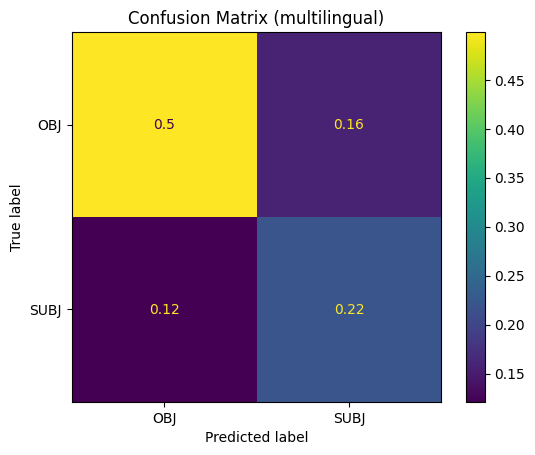

In [116]:
test_predictions, test_labels, _ = trainer.predict(test_data)

stats = evaluate_metrics((test_predictions, test_labels))

test_predictions = np.argmax(test_predictions, axis=1)

print(stats)
results['multi'] = stats

cm = confusion_matrix(test_labels, test_predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix (multilingual)")
plt.show()

In [118]:
pd.DataFrame(results).T.sort_values(by='macro_F1', ascending=False)

,macro_F1,macro_P,macro_R,SUBJ_F1,SUBJ_P,SUBJ_R,accuracy
german,0.837261,0.833847,0.841166,0.784141,0.767241,0.801802,0.854599
bulgarian,0.757477,0.759539,0.756062,0.717703,0.735294,0.700935,0.764000
italian,0.742697,0.738231,0.747933,0.626335,0.606897,0.647059,0.795322
multi,0.696631,0.693340,0.702225,0.612463,0.582393,0.645807,0.719983
english,0.675150,0.736784,0.655375,0.479167,0.657143,0.377049,0.793388
arabic,0.565763,0.576492,0.568669,0.461268,0.534694,0.405573,0.590909


---

In [119]:
model_card = "answerdotai/ModernBERT-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = AutoModelForSequenceClassification.from_pretrained(
    model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [120]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map: 100%|██████████| 484/484 [00:00<00:00, 13775.24 examples/s]


In [121]:
# Define training args
training_args = TrainingArguments(
    output_dir= "models",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #bf16=True, # bfloat16 training 
    #optim="adamw_torch_fused", # improved optimizer 
    # logging & evaluation strategies
    #logging_strategy="steps",
    #logging_steps=100,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    #use_mps_device=True,
    metric_for_best_model="macro_F1",
    # push to hub parameters
    #push_to_hub=True,
    #hub_strategy="every_save",
    #hub_token=HfFolder.get_token(),
)

In [122]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights,
    device=device,
)

In [123]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.614003,0.689827,0.708063,0.697410,0.660287,0.775281,0.575000,0.692641
2,No log,0.506987,0.738491,0.741622,0.738176,0.760000,0.730769,0.791667,0.740260
3,No log,0.687563,0.717577,0.727573,0.722072,0.700461,0.783505,0.633333,0.718615
4,No log,0.756629,0.720767,0.721435,0.721622,0.722581,0.746667,0.700000,0.720779
5,No log,1.002161,0.712055,0.714500,0.713795,0.707692,0.748837,0.670833,0.712121
6,No log,1.065978,0.712120,0.713364,0.713288,0.711497,0.742081,0.683333,0.712121


TrainOutput(global_step=312, training_loss=0.25890369904346955, metrics={'train_runtime': 90.0931, 'train_samples_per_second': 55.276, 'train_steps_per_second': 3.463, 'total_flos': 473959555589520.0, 'train_loss': 0.25890369904346955, 'epoch': 6.0})

{'macro_F1': 0.7079889807162534, 'macro_P': 0.7091575091575091, 'macro_R': 0.7068653201702744, 'SUBJ_F1': np.float64(0.5619834710743802), 'SUBJ_P': np.float64(0.5666666666666667), 'SUBJ_R': np.float64(0.5573770491803278), 'accuracy': 0.78099173553719}


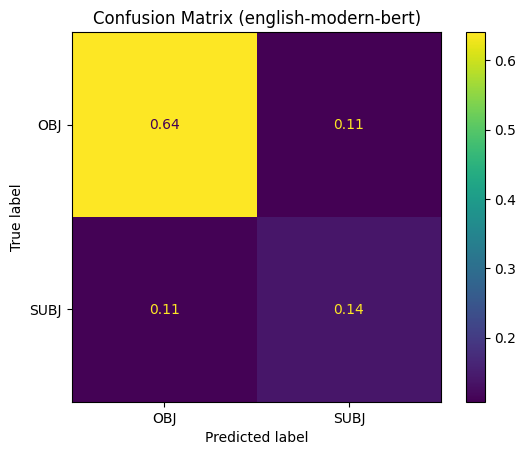

In [124]:
test_predictions, test_labels, _ = trainer.predict(test_data)

stats = evaluate_metrics((test_predictions, test_labels))

test_predictions = np.argmax(test_predictions, axis=1)

print(stats)
results['english-modern-bert'] = stats

cm = confusion_matrix(test_labels, test_predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix (english-modern-bert)")
plt.show()

In [125]:
pd.DataFrame(results).T.sort_values(by='macro_F1', ascending=False)

,macro_F1,macro_P,macro_R,SUBJ_F1,SUBJ_P,SUBJ_R,accuracy
german,0.837261,0.833847,0.841166,0.784141,0.767241,0.801802,0.854599
bulgarian,0.757477,0.759539,0.756062,0.717703,0.735294,0.700935,0.764000
italian,0.742697,0.738231,0.747933,0.626335,0.606897,0.647059,0.795322
english-modern-bert,0.707989,0.709158,0.706865,0.561983,0.566667,0.557377,0.780992
multi,0.696631,0.693340,0.702225,0.612463,0.582393,0.645807,0.719983
english,0.675150,0.736784,0.655375,0.479167,0.657143,0.377049,0.793388
arabic,0.565763,0.576492,0.568669,0.461268,0.534694,0.405573,0.590909
